# Nested logit model (NL)

- This notebook was written by Evangelos Paschalidis.
- Acknowledgement of the material is required.
- The code comes with no guarantees and the author cannot be held liable for any errors.
- Contact: evangelos.paschalidis@epfl.ch

## Overview

This notebook covers the estimation of a nested logit model in python with maximum likelihhod estimation:

* Load necessary packages
* Define variables and parameters to estimate
* Model specification
* Model output

## Context: Mode choice

Imagine the following situation where an individual must choose between three mode alternatives:
* Tram
* Metro
* Bus

A typical approach to model such behaviour is via Stated Preference (SP) surveys.

In SP surveys, an individual choses among a number of alternatives in a series of choice tasks

Each alternative is characterised by a number of different attributes such as travel time, travel cost etc.

### Example of a SP survey

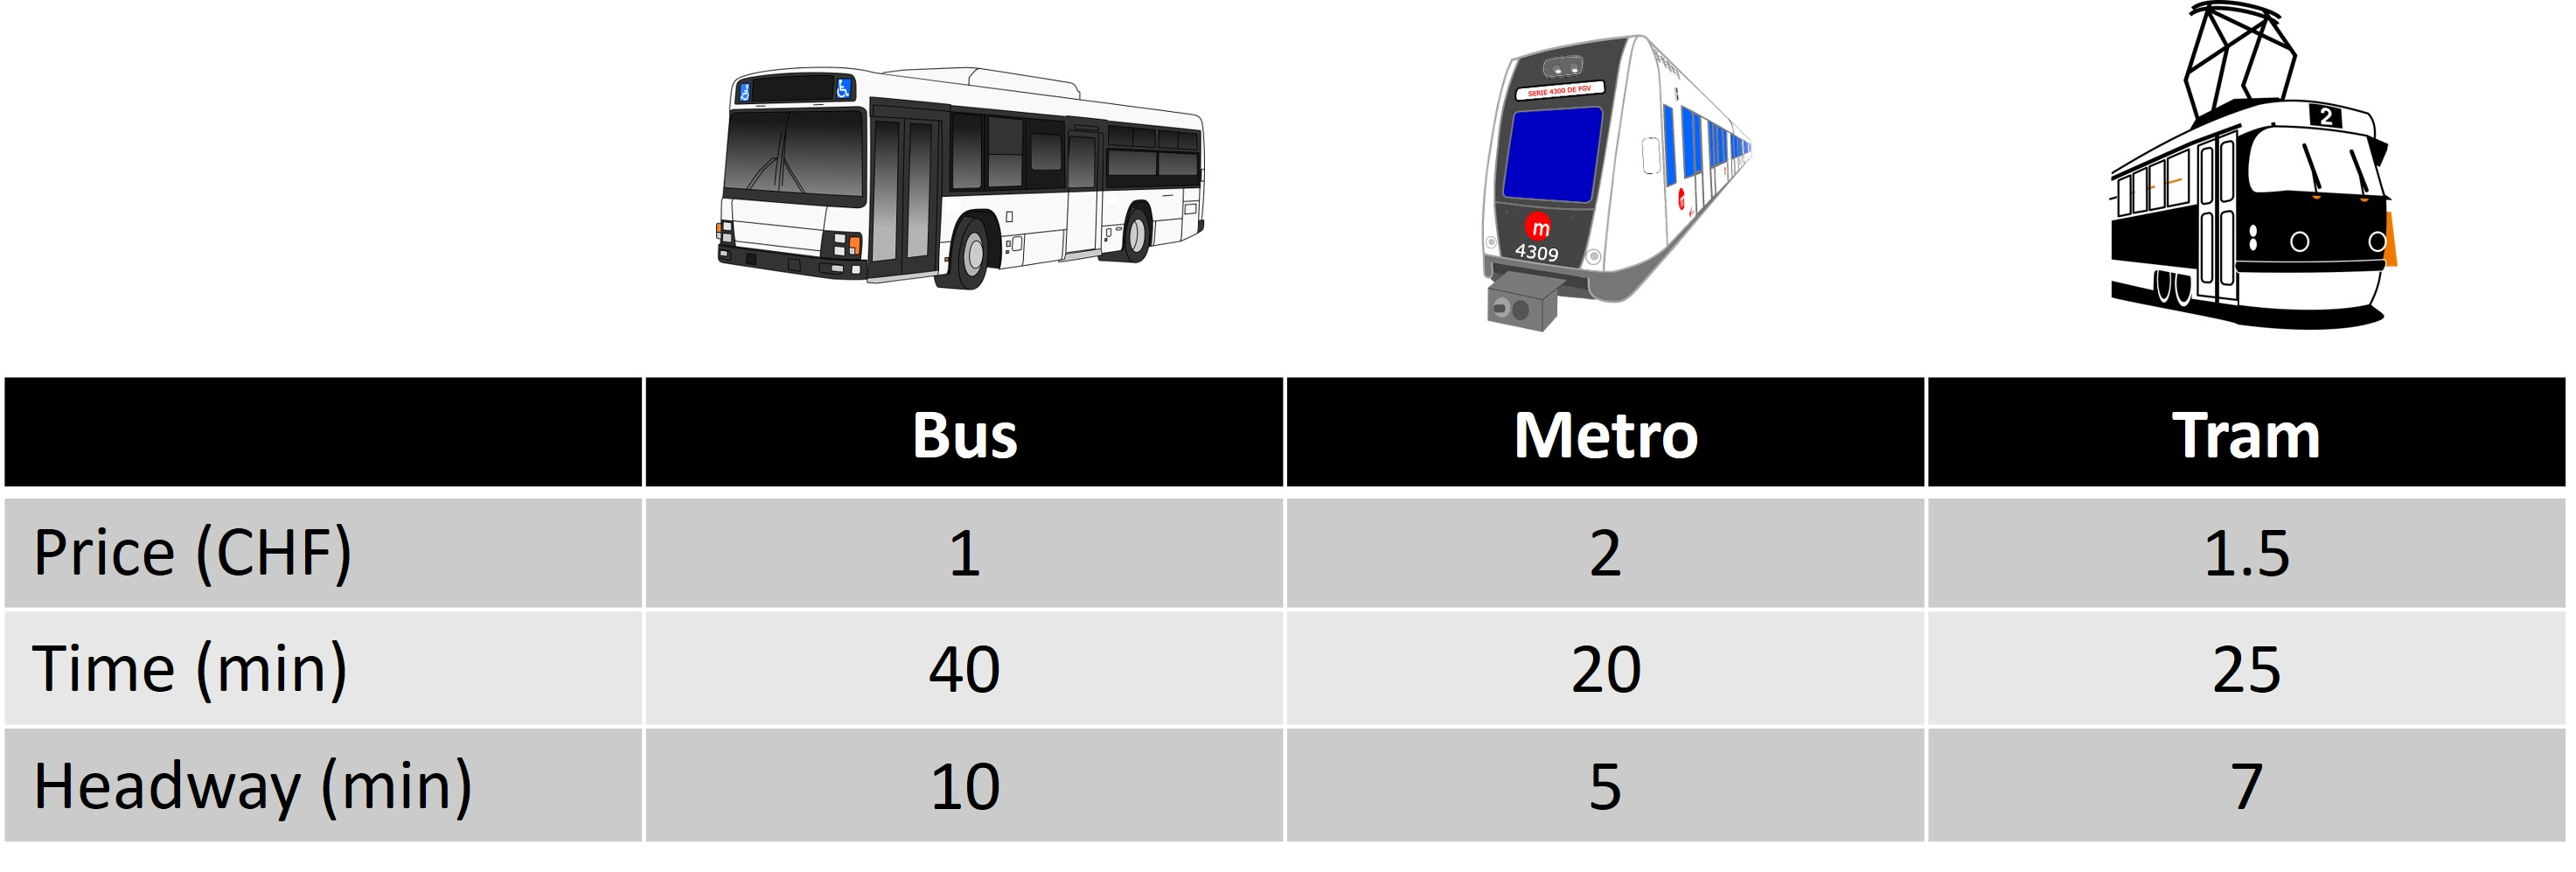

## Model specification

## Load packages

Before we estimate the model let's load some packages that we are going to need. When importing a package, it is common to rename it using an abbreviation.

In [ ]:
import pandas as pd # for data frame processing
import numpy as np # for some statistical procedures
from scipy.optimize import minimize # optimisation routine for parameter estimation
from scipy.stats import norm # normal distribution density function
import numdifftools as nd # we use this to calculate t-ratios and p-values
from scipy.stats import t # we use this to calculate the CFDs needed for t-ratios and p-values
import csv # we need this to store our parameters as csv
from scipy.special import roots_legendre # we use this to generate nodes for numerical integration
from scipy.stats import qmc # we use this to generate nodes for numerical integration
from collections import OrderedDict
import copy
from collections import defaultdict

### Let's give a name to our model

In [ ]:
model_name = 'NL_model' # Name we want to give to our model (this is used when saving the output)

### Panel structure
We need to define whether our data is panel (i.e. multiple observations per individual) or not

In [ ]:
panel = 0 # switch to 1 if data is panel (any other value if not panel)

### Define if we use mixing

In [ ]:
mixing = 0 # switch to 1 if we apply mixing - random effects (any other value if no mixing applied)

## Load the data

Now it is time to load the data. We can do that using the piece of code below.

**Important!** Make sure the data is in the same folder with the notebook file

In [ ]:
# Command to load the data
data = pd.read_table('data_mode_choice_mixed.txt')

if panel==0:
    data['ID'] = range(1, len(data) + 1)

# Number of observations (we need this to caclulate goodness-of-fit indices)
Nobs = data.shape[0]

## Print the data

Let's quickly print the data. Simply type *data* in the field below

(If we open our data set with a different name e.g. *database* then the latter should be used)

* Please make sure to change the name througout the whole script if you change the data frame name.

In [ ]:
# Type "data" in this field (without the quotation) and run the cell (Shift + return)
data

## Print the variable names (columns)

We can also print the variable names only using the piece of code below

* This is useful during model specification to easily access the column names

In [ ]:
print(data.columns)

## Variable definition

We need to define the variables (as numpy arrays) that we will use in our model.

* The arrays can have any name but it is more convenient to use the same name as in the data set.
* The *".reshape(-1, 1)"* is not necessary now but it is required if we include mixing (random effects) in our model.
    * Reshape allows to multiply arrays of different dimensions.

##### Define explanatory (independent) variables and choice

In [ ]:
# Example variable_name = np.array(data['variable_name']).reshape(-1, 1)

choice = np.array(data['choice']).reshape(-1, 1)
tt_bus = np.array(data['tt_bus']).reshape(-1, 1)
tt_metro = np.array(data['tt_metro']).reshape(-1, 1)
tt_tram = np.array(data['tt_tram']).reshape(-1, 1)
tc_bus = np.array(data['tc_bus']).reshape(-1, 1)
tc_metro = np.array(data['tc_metro']).reshape(-1, 1)
tc_tram = np.array(data['tc_tram']).reshape(-1, 1)
hw_bus = np.array(data['hw_bus']).reshape(-1, 1)
hw_metro = np.array(data['hw_metro']).reshape(-1, 1)
hw_tram = np.array(data['hw_tram']).reshape(-1, 1)

#### Define the whole data set variables
* It may be the case that we have too many variables in the data
* In that case it makes more sense to define all variables instead of doing it individually
* We do that in the code below (activate to use)

In [ ]:
# def attach(df):
#     for col in df.columns:
#         globals()[col] = np.array(df[col]).reshape(-1, 1)

# attach(data)

##### Define the ID variable

In [ ]:
# Example ID = np.array(data['ID']) # ID does not need to be reshaped

ID = np.array(data['ID']) # ID does not need to be reshaped

##### Delete the data frame
*We may want to delete the data frame to preserve some RAM (suggested for very large data sets)*

In [ ]:
# Activate to delete the data frame.
# del[data]

## Model specification

We now need to create a function that includes our model.

* Python functions are defined as: def *function_name*(parameters):
* We end a function as: return *value_to_return*

In the current implementation we specify two different functions as:
* *function 1* calculates the log likelihood per observations
* *function 2* calculates the sum of log likelihood taking as input the result from *function 1*

*We define two different functions to be more flexible in the post estimation processing later in the code*

We use some python (numpy) functions such '*exp*' or '*log*'. To execute these in the current example, we need to also call numpy; hence, we have *np.exp()* and *np.log()*.

### Define parameters and starting values

Ultimately, we want to estimate the value of some parameters that maximise the likelihood of our observations of the dependent variable.

Before starting the estimation process, we need to define some starting values for the parameters to be estimated. The typecal starting value is zero.

In [ ]:
betas_start = {"asc_tram": 0, "asc_metro": 0, "beta_tc": 0, "beta_tt": 0, "beta_hw": 0,
              "mu_rail": 1}

### Load old parameter estimates results

Sometimes, we want to use results from old models as starting values.
* To do that, we will load the iteration file from a previous estimation
* Please note that only values of parameters with same names with our current model will be copied

In [ ]:
# ### Activate this cell to load old results ###

# # Open old iteration file
# betas_old = pd.read_csv('model_name_iterations.csv')

# # Keep last row
# betas_old = betas_old.tail(1)

# # Convert to dictionary
# betas_old = betas_old.to_dict(orient='records')[0]

# # Copy values from old to start for keys that are common to both dictionaries
# for key in betas_old:
#     if key in betas_start:
#         betas_start[key] = betas_old[key]

# # Delete old estimates
# del[betas_old]

#### Method 2: Code for simulation
* We use this part of the code for mixed logit (or random effects models in general)
* The simulation code will first generate uniform random numbers (0, 1).
* We then transform them to normally distributed


In [ ]:
# # First let's set the number of draws
# Ndraws = 1000

In [ ]:
# # This piece of code is generating Halton draws using the number of nodes we set just above
# nIndiv = len(set(ID))
# draws = ['draws_tt','draws_tram','draws_metro']
# nDim = len(draws)
# tasks = (pd.DataFrame(ID).value_counts(sort = False)) # observations per ID

# sampler = qmc.Halton(d=nDim, scramble=False)
# sample = pd.DataFrame(sampler.random(n=Ndraws*nIndiv+Ndraws)) # +Ndraws
# sample = sample[(Ndraws-1):(Ndraws*nIndiv+Ndraws-1)]

# cols = len(sample.columns)

# for i in range(cols):
#     # print(i)
#     sample1 = np.array(sample.loc[:,i])
#     sample1=pd.DataFrame(np.reshape(sample1,(nIndiv,Ndraws)))
#     sample_rep =sample1.loc[sample1.index.repeat(tasks)]
#     globals()[draws[i]] = sample_rep

#### Here we convert the uniform draws to the target distribution

In [ ]:
# # Convert to normal distribution (or any other preferred)
# # Example for normal distribution: draws_param1 = norm.ppf(draws_param1)

# draws_tt = norm.ppf(draws_tt)
# draws_tram = norm.ppf(draws_tram)
# draws_metro = norm.ppf(draws_metro)

### Define generating function of nested logit (do not change the code below!)
This bit of code is a bit ugly. We basically need to create the generating function of the nested logit model to plug in the utility functions. The generating function follows the form:

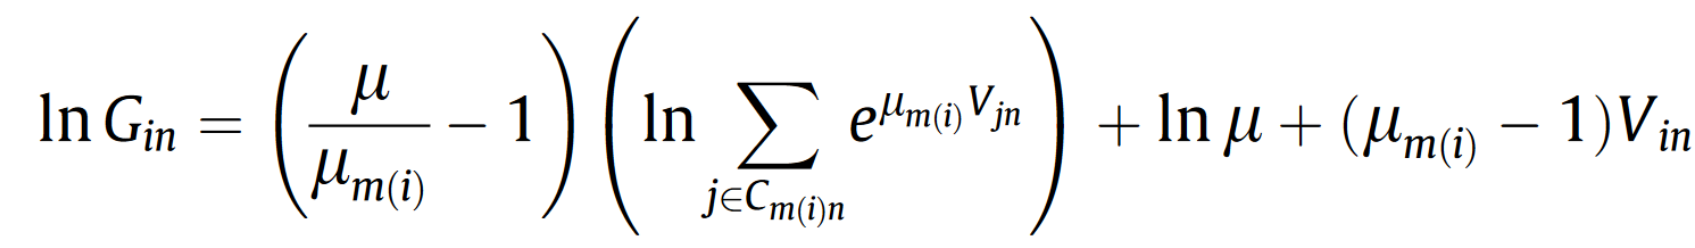

In [ ]:
def G_NL(Utility,alts,av,nests,mu_nests):
        
        # First we create a function that checks if all utilities have the same width.
        # We need this feature in the mixed logit model case.
        # In mixed logit sizes may vary as only some utilities may have random components.
        
        def have_same_columns(d):
            num_columns = {len(v[0]) if isinstance(v, list) else v.shape[1] for v in d.values()}
            return len(num_columns) == 1
        
        same_cols = have_same_columns(Utility)*1
        
        # If we detect difference in the number of columns we replicate those with fewer cases.
        
        def replicate_columns(data):
            # Determine the maximum number of columns (N) among all items
            max_columns = max(len(row) for item in data.values() for row in item)

            # Replicate columns for items with only one column and convert to NumPy arrays
            for key, value in data.items():
                rows = len(value)
                if len(value[0]) == 1:  # Check if the item has only one column
                    # Replicate the single column to match max_columns and keep the number of rows the same
                    replicated_array = np.tile(value, (1, max_columns)).astype(float)
                    data[key] = replicated_array
                else:
                    # Ensure the item is a NumPy array of floats
                    data[key] = np.array(value, dtype=float)

            return data
        
        # Create a new dictionary for utility
        
        if same_cols<1:
            Utility_nl = replicate_columns(Utility)
        
        else:
            Utility_nl = copy.deepcopy(Utility)

        # Get unique values in nests item
        # We do this for our nest calculations later
        all_values = []
        for value in nests.values():
            if isinstance(value, np.ndarray):
                # Extend the list if the value is a NumPy array
                all_values.extend(value)
            else:
                    # Append the value if it's not a NumPy array
                    all_values.append(value)

        # Find unique values
        compare_array = np.unique(all_values)
        
        # A dictionary with items equal to the number of nests
        # The values are 0/1 if an alternative belongs to the nest
        new_dict = OrderedDict()

        for key, nest_values in nests.items():
            # Convert nest_values to an array if it is not already
            if not isinstance(nest_values, np.ndarray):
                nest_values = np.array([nest_values])

            # Create the tuple based on comparison
            match_tuple = tuple(int(value in nest_values) for value in compare_array)

            # Assign the tuple to the corresponding key in the new dictionary
            new_dict[key] = match_tuple
        
        ####################################################################
        ####################################################################
        
        # We prepare the term (mu/mu_m-1) for each nest
        lgG0 = [(mu_logit / v)-1 for v in mu_nests.values()]
        lgG0 = OrderedDict(zip(nests.keys(), lgG0))
        
        ####################################################################
        ####################################################################
        
        # We replicate utilities to the number of nests.
        
        Utility_nl_new = {}
        for j in range(1, len(mu_nests) + 1):
            Utility_nl_new[f"new_item{j}"] = Utility_nl.copy()
        
        #################################################################
        #################################################################
        
        # We multiply with the nest parameter, then we exponentiate.
        
        Utility_nl_new2 = {}
        
        for ii in range(len(mu_nests)):
            item_at_position = list(mu_nests.values())[ii]
            
            matrix_at_position = list(Utility_nl_new.values())[ii]
            matrix_at_position = [v*item_at_position for v in matrix_at_position.values()]
            matrix_at_position = np.exp(matrix_at_position)
            matrix_at_position = OrderedDict(zip(Utility.keys(), matrix_at_position))
        
            Utility_nl_new2[ii] = matrix_at_position
        
        #################################################################
        #################################################################
        
        # We multiply with the nest indicators
        
        Utility_nl_new3 = {}
        
        for ii in range(len(new_dict)):
            item_at_position = list(new_dict.values())[ii]
            
            matrix_at_position = list(Utility_nl_new2.values())[ii]
            
            matrix_at_position = [item_at_position[i] * value for i, value in enumerate(matrix_at_position.values())]            
            matrix_at_position = OrderedDict(zip(Utility.keys(), matrix_at_position))
        
            Utility_nl_new3[ii] = matrix_at_position
        
        del(Utility_nl_new2)
        
        #################################################################
        #################################################################
        
        # We calculate the log sum
        
        Utility_nl_new4 = {}
        
        for ii in range(len(Utility_nl_new3)):
            
            matrix_at_position = list(Utility_nl_new3.values())[ii]
            
            cols = len(list(matrix_at_position.values())[0][0])
            rows = len(list(matrix_at_position.values())[0])
            
            sum_matrix = np.zeros((rows, cols))
            
            for jj in range(len(matrix_at_position)):
                matr1 = list(matrix_at_position.values())[jj]
                sum_matrix = sum_matrix+matr1
            
            sum_matrix = np.log(sum_matrix)
            Utility_nl_new4[ii] = sum_matrix
        
        del(Utility_nl_new3)
        
        #################################################################
        #################################################################
        
        # We calculate the first part of the generating function
        
        Utility_nl_new5 = {}
        
        for ii in range(len(lgG0)):
            item_at_position = list(lgG0.values())[ii]
            
            matrix_at_position = list(Utility_nl_new4.values())[ii]
            matrix_at_position = matrix_at_position*item_at_position+np.log(mu_logit)
        
            Utility_nl_new5[ii] = matrix_at_position
        
        del(Utility_nl_new4)
        
        #################################################################
        #################################################################
        
        
        ################################################################
        ################################################################
        
        # We need a function that multiplies the nest parameters to some indicators of belogning in a nest.
        
        def dict_mult(dict1,dict2):
            dict3 = OrderedDict()
            
            for new_key, multipliers in dict2.items():
                # Get the keys and values (arrays) from lgG3
                keys = np.array(list(dict1.keys()))
                values = np.array(list(dict1.values()))
                
                keys_0 = np.array(list(dict2.keys()))
                values_0 = np.array(list(dict2.values()))
                
                for i in range(len(keys)):
                    aa = (values[i]-1)*values_0[i]
                    dict3[keys_0[i]] = aa
            return dict3
        
        ################################################################
        ################################################################
            
        # We implement the function on mu_m's
        lg_mus = dict_mult(mu_nests,new_dict)
        
        ################################################################
        ################################################################
        
        # We multiply the nest parameters with the utility functions.
        
        lg_U = OrderedDict()

        for ii in range(len(lg_mus)):
            item_at_position = list(lg_mus.values())[ii]
            
            Utility_nl_new6 = {}
            
            for jj in range(len(Utility_nl)):
                matrix_at_position = list(Utility_nl.values())[jj]
                matrix_at_position = matrix_at_position*item_at_position[jj]
            
                Utility_nl_new6[jj] = matrix_at_position
        
            lg_U[ii] = Utility_nl_new6
        
        ################################################################
        ################################################################
        
        # We compute the total value of the generating function.
        
        logG0 = OrderedDict()
        
        for ii in range(len(lg_U)):
            item_at_position = list(Utility_nl_new5.values())[ii]
            matrix_at_position = list(lg_U.values())[ii]
            
            Utility_nl_new7 = {}
            
            for jj in range(len(matrix_at_position)):
                matrix_at_position0 = list(matrix_at_position.values())[jj]
                matrix_at_position0 = matrix_at_position0+item_at_position
            
                Utility_nl_new7[jj] = matrix_at_position0
        
            logG0[ii] = Utility_nl_new7
        
        ################################################################
        ################################################################
        
        # We correct the generating function (set to 0 if not in a nest).
        
        logG00 = OrderedDict()
        
        for ii in range(len(lg_U)):
            item_at_position = list(new_dict.values())[ii]
            matrix_at_position = list(logG0.values())[ii]
            
            Utility_nl_new8 = {}
            
            for jj in range(len(matrix_at_position)):
                matrix_at_position0 = list(matrix_at_position.values())[jj]
                matrix_at_position0 = matrix_at_position0*item_at_position[jj]
            
                Utility_nl_new8[jj] = matrix_at_position0
        
            logG00[ii] = Utility_nl_new8
        
        ################################################################
        ################################################################
        
        # We take the same across utilities.
        
        def sum_subdict_items(input_dict):
            # Initialize the result dictionary
            result_dict = defaultdict(lambda: np.zeros((len(next(iter(next(iter(input_dict.values())).values()))), 
                                                        len(next(iter(next(iter(input_dict.values())).values()))[0]))))

            # Iterate and sum the matrices
            for subdict in input_dict.values():
                for j, matrix in subdict.items():
                    result_dict[j] += np.array(matrix)

            # Convert the results to NumPy arrays
            for key in result_dict:
                result_dict[key] = np.array(result_dict[key])

            return dict(result_dict)
                
        logG000 = sum_subdict_items(logG00)
        
        ################################################################
        ################################################################
        
        # We correct for the availabilities
        
        logG = OrderedDict()
        
        for ii in range(len(logG000)):
            item_at_position = list(av.values())[ii]
            matrix_at_position = list(logG000.values())[ii]
        
            logG[ii] = item_at_position*matrix_at_position
        
        ################################################################
        ################################################################
        
        return logG
    

#### Add the scale of the logit model
**Leave this to 1 unless you want to experiment**

In [ ]:
mu_logit = 1

### Function 1: log likelihood (LL)
This function calculates the log likelihood per observation

In [ ]:
def LL(betas): # betas is a vector with the parameters we want to estimate
   
    # First let's define the parameters to be estimated.
    # The parameter names are imported directly from 'beta_start' that we defined earlier
    
    for pn in range(len(betas_start.values())):
        globals()[np.array(list(betas_start.keys()))[pn]] = betas[pn]
    
    # We need to start by defining the utility functions
    # Please make sure that you are using the same names for the parameters as those defined in 'betas_start'
    
    # First we create a dictionary for mapping the alternatives
    alts = OrderedDict([(1, (choice==1)), (2, (choice==2)), (3, (choice==3))])
    
    # Then we set availabilities
    av = OrderedDict([(1, 1), (2, 1), (3, 1)])
    
    # It is time to define the nests
    nests = OrderedDict([("nest_rail", np.array([1,2])), ("nest_road", np.array([3]))])
    
    # Now we define the mu of each nest
    mu_nests = OrderedDict([("mu_rail", mu_rail), ("mu_road", 1)])
    
    # Then we add the utility functions per mode
    U_tram = asc_tram + beta_tc * tc_tram + beta_tt * tt_tram + beta_hw*hw_tram
    U_metro = asc_metro + beta_tc * tc_metro + beta_tt * tt_metro + beta_hw*hw_metro
    U_bus = beta_tc * tc_bus + beta_tt * tt_bus + beta_hw*hw_bus
    
    # We add the utilities in a dictionary
    Utility = OrderedDict([(1, U_tram), (2, U_metro), (3, U_bus)])
    
    # We call the generating function
    lnG = G_NL(Utility,alts,av,nests,mu_nests)
    
    def Nlogit(Utility,alts,av,lnG):
        
        # We start by adding the generating function in the utility
        Utility_lnG = [v1 + v2 for (_, v1), (_, v2) in zip(Utility.items(), lnG.items())]
        
        # Convert Utility to dictionary
        Utility = OrderedDict(zip(Utility.keys(), Utility_lnG))
        
        # Take the exp of utilities
        Utility = {key: np.exp(value) for key, value in Utility.items()}
        
        # Apply availabilities
        Utility_av = [v1 * v2 for (_, v1), (_, v2) in zip(Utility.items(), av.items())]
        Utility = dict(zip(Utility.keys(), Utility_av))
        del(Utility_av)
        
        # Take sum of utilities
        Usum = sum(Utility.values())
        
        # Calculate probabilities
        Utility = {key: value / Usum for key, value in Utility.items()}
        
        # Calculate probabilities
        Utility_p = [v1 * v2 for (_, v1), (_, v2) in zip(Utility.items(), alts.items())]
        Utility = dict(zip(Utility.keys(), Utility_p))
        del(Utility_p)
        
        # Take sum of utilities
        plogit = sum(Utility.values())
        
        return plogit
    
    P = Nlogit(Utility,alts,av,lnG)
    
    ############################################################################################################
    ############################################################################################################
    # - Now this below is relevant if we have panel data and apply mixing (Do not change this piece of code!) -#
    if panel == 1:
    # Do it as panel
        P = pd.DataFrame(P)
        P = pd.concat([pd.Series(ID), pd.DataFrame(P)], axis=1, ignore_index=True)
        P.rename(columns={P.columns[0]: 'ID'},inplace=True)
    
        # We take the product of probabilities per individual per draw and then delete the ID column
        P = P.groupby('ID', as_index=False).prod()
        P = P.drop('ID', axis=1)
   
    if mixing == 1:
        # We take the average per row to get the average probability per individual (if mixing == 1)
        
        if panel == 1:
            P['mean'] = P.mean(axis=1)
            P = np.array(P['mean'])
        
        if panel == 0:
            P = pd.DataFrame(P)
            P = pd.concat([pd.Series(ID), pd.DataFrame(P)], axis=1, ignore_index=True)
            P.rename(columns={P.columns[0]: 'ID'},inplace=True)
    
            # We take the product of probabilities per individual per draw and then delete the ID column
            P = P.groupby('ID', as_index=False).prod()
            P = P.drop('ID', axis=1)
            P['mean'] = P.mean(axis=1)
            P = np.array(P['mean'])
            
    P = np.array(P)
    ### --- This is where the panel data approach ends. --- ###
    ############################################################################################################
    ############################################################################################################
    
    # We then take the log of the density function
    logprob = np.log(P)
    
    return logprob

### Function 2: sum of log likelihood (SLL)
This function simply takes the sum of log likelihood that we calculated with the first function

In [ ]:
def SLL(betas):
    return -sum(LL(betas))

## Model estimation

### Warnings

Sometimes, optimisation procedures may 'overdo' it with warnings during estimation.
We can supress these with the piece of code below (not always advisable)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Estimation

Now it is finally time to run our estimation command.
We use an optimisation algorith called 'BFGS'.

**Do not to edit the lines of code below (except optimisation routine if needed).**

In [ ]:
# This will give us the initial loglikelihood value as an output
def callback1(betas):
    print("Current log likelihood:", -SLL(betas))

# This function will allow as to store parameter estimates during iterations
# Initialise list to store parameter values
parameter_values = [np.array(list(betas_start.values()))]
# Then define the function
def callback2(betas):    
    parameter_values.append(betas)
    column_names = list(betas_start.keys())
    with open(f'{model_name}_iterations.csv','w',newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(column_names)
        writer.writerows(parameter_values)

# Now let's combine the two callback functions
def combined_callback(betas):
    callback1(betas)
    callback2(betas)
        
print("Initial log likelihood:", -SLL(np.array(list(betas_start.values()))))

# Choose optimisation routine (preferably BFGS)
optimiser = 'BFGS' # BFGS or L-BFGS-B or nelder-mead

result = minimize(SLL, np.array(list(betas_start.values())), method=optimiser,callback=combined_callback, 
                  options={'disp':False})

print("Final log likelihood:", -result.fun)

## Post estimation processing

We evaluate our parameter estimates using t-ratios (or p-Values).

In maximum likelihood estimation, we extract these from the variance-covariance matrix of the parameters.

The variance covariance matrix is not readily available but we need to calculate it.

This is done with the code below.

**DO NOT EDIT THE CHUNK OF CODE BELOW!**

In [ ]:
# Vector of parameter estimates
parameters = result['x'] 

# Calculate hessian
print("Calculating Hessian, please wait (this may take a while...)")
Hess = nd.Hessian(SLL)
hessian = Hess(parameters)
inv_hessian = np.linalg.inv(hessian)

# Parameter statistics
dof = Nobs - len(betas_start) - 1
se = np.sqrt(np.diag(inv_hessian)) # Standard errors
tratio = parameters/se # t-ratios
p_value = (1-t.cdf(np.abs(tratio),dof)) * 2 # p-values


# --- Sandwich estimator --- #

# The sandwich estimator provides the "robust" s.e., t-ratios and p-values.
# These should be preferred over the classical parameter statistics.

# We first need the gradients at the solution point
Grad = nd.Gradient(LL)
gradient = Grad(parameters)

# Then we need to calculate the B matrix
B = np.array([])
for r in range(gradient.shape[0]):
    Bm = np.zeros([len(betas_start),len(betas_start)])
    gradient0 = gradient[r,:]
    for i in range(len(gradient0)):
            for j in range(len(gradient0)):
                element = gradient0[i]*gradient0[j]
                Bm[i][j] = element
    if B.size==0:
                    B = Bm
    else:
                    B = B+Bm

# Finally we "sandwich" the B matrix between the inverese hessian matrices
BHHH = (inv_hessian)@(B)@(inv_hessian)

print("... Done!!")

# Now it is time to calculate some "robust" parameter statistics
rob_se = np.sqrt(np.diag(BHHH)) # robust standard error
rob_tratio = parameters/rob_se # robust t-ratio
rob_p_value = (1-t.cdf(np.abs(rob_tratio),dof)) * 2 # robust p-value

## Results
Finally, we got our results. Let's print them!

The outputs that we receive are:
* Estimates: These are the values of our parameters. We must check if the sign is consistent with our expectations
* s.e.: Standard errors of the parameters
* tratio: t-ratio of the parameters (significant if absolute value > 1.96)
* p_value: p-value of the parameters (significant if < 0.05)

The parameter statistics also have their **robust** versions. These should be preferred as they are less susceptible to weakly specified models.

In [ ]:
arrays = np.column_stack((np.array(list(betas_start.keys())),parameters,se,tratio,p_value,rob_se,rob_tratio,rob_p_value))
results = pd.DataFrame(arrays, columns = ['Parameter','Estimate','s.e.','t-ratio0','p-value',
                                          'Rob s.e.','Rob t-ratio0','Rob p-value'])

results[['Estimate','s.e.','t-ratio0','p-value','Rob s.e.','Rob t-ratio0','Rob p-value']] = (
results[['Estimate','s.e.','t-ratio0','p-value','Rob s.e.','Rob t-ratio0','Rob p-value']].apply(pd.to_numeric, errors='coerce'))
numeric_cols = results.select_dtypes(include='number').columns
results[numeric_cols] = results[numeric_cols].round(3)
results # print results

## Goodness-of-fit indices

Let's calculate some goodness-of-fit indices now (do not edit)

In [ ]:
# First let's calculate the GoF indices

rho_squared = 1 - ((-result.fun)/(-SLL(np.zeros(len(betas_start)))))
adj_rho_squared = 1 - (((-result.fun)-len(betas_start))/(-SLL(np.zeros(len(betas_start)))))

AIC = 2*len(betas_start) - 2*(-result.fun)
BIC = len(betas_start)*np.log(Nobs) - 2*(-result.fun)

LL0t = "Log likelihood at zeros:" + str(-SLL(np.zeros(len(betas_start))))
LLinit = "Initial log likelihood:" + str(-SLL(np.array(list(betas_start.values()))))
LLfin = "Final log likelihood:" + str(-result.fun)

rs1 = "rho squared="+str(rho_squared)
rs2 = "adjusted rho squared="+str(adj_rho_squared)
ac = "AIC="+str(AIC)
bc = "BIC="+str(BIC)

# Then let's print the GoF indices

print(LL0t)
print(LLinit)
print(LLfin)

print(rs1)
print(rs2)
print(ac)
print(bc)

## Save output

We can save our output using the code below (do not edit):

In [ ]:
with open(f"{model_name}_results.txt", 'w') as f:
    f.write(f'{LL0t}\n')
    f.write(f'{LLinit}\n')
    f.write(f'{LLfin}\n')
    f.write(f'{rs1}\n')
    f.write(f'{rs2}\n')
    f.write(f'{ac}\n')
    f.write(f'{bc}\n')
    results.to_csv(f, index=False, sep='\t')
results.to_csv(f'{model_name}_results.csv', index=False)